## 导入相关模块

In [31]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 15, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### 本案例使用真实的心电图 (ECG) 数据来检测患者心跳的异常情况。我们将一起构建一个 LSTM 自动编码器，使用来自单个心脏病患者的真实心电图数据对其进行训练，并将在新的样本中，使用训练好的模型对其进行预测分类为正常或异常来来检测异常心跳。

## 本案例主要围绕以下几大核心展开。
### 从时间序列数据中准备用于异常检测的数据集
### 使用 PyTorch 构建 LSTM 自动编码器
### 训练和评估模型
### 设定异常检测的阈值
### 将新的样本分类为正常或异常

## 数据集
#### 该数据集包含 5,000 个通过 ECG 获得的时间序列样本，样本一共具有 140 个时间步长。每个序列对应于一个患有充血性心力衰竭的患者的一次心跳。
#### 心电图（ECG 或 EKG）是一种通过测量心脏的电活动来检查心脏功能的测试。每一次心跳，都会有一个电脉冲（或电波）穿过您的心脏。这种波会导致肌肉挤压并从心脏泵出血液。
#### 我们有 5 种类型的心跳类别，他们分别是：
#### 正常 (N)
#### 室性早搏 (R-on-T PVC)
#### 室性早搏 (PVC)
#### 室上性早搏或异位搏动（SP 或 EB）
#### 未分类的搏动 (UB)。

### 假设心脏健康，典型心率为每分钟 70 到 75 次，每个心动周期或心跳大约需要 0.8 秒才能完成该周期。频率：每分钟 60–100 次（人类）持续时间：0.6–1 秒（人类）

In [32]:
#如果你的设备安装有 GPU，这将是非常好的，因为他的运行速度更快，可以节约你宝贵的时间。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 数据有多种格式，我们将加载.arff格式的文件到pandas数据帧中。

In [33]:
with open('././ECG5000/ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)
with open('././ECG5000/ECG5000_TEST.arff') as f:
    test = a2p.load(f)

### 把训练和测试数据组合成一个单一的数据框。两者的加成，将为我们提供更多数据来训练我们的自动编码器。

In [34]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [35]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


### 我们有5000个例子。每一行代表一个心跳记录。我们重新命名所有的类。并将最后一列重命名为target，这样在后面引用它将更为方便。

In [36]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## 探索性数据分析

In [37]:
# 通过函数value_counts()可以看看每个不同的心跳类分别有多少个样本。
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

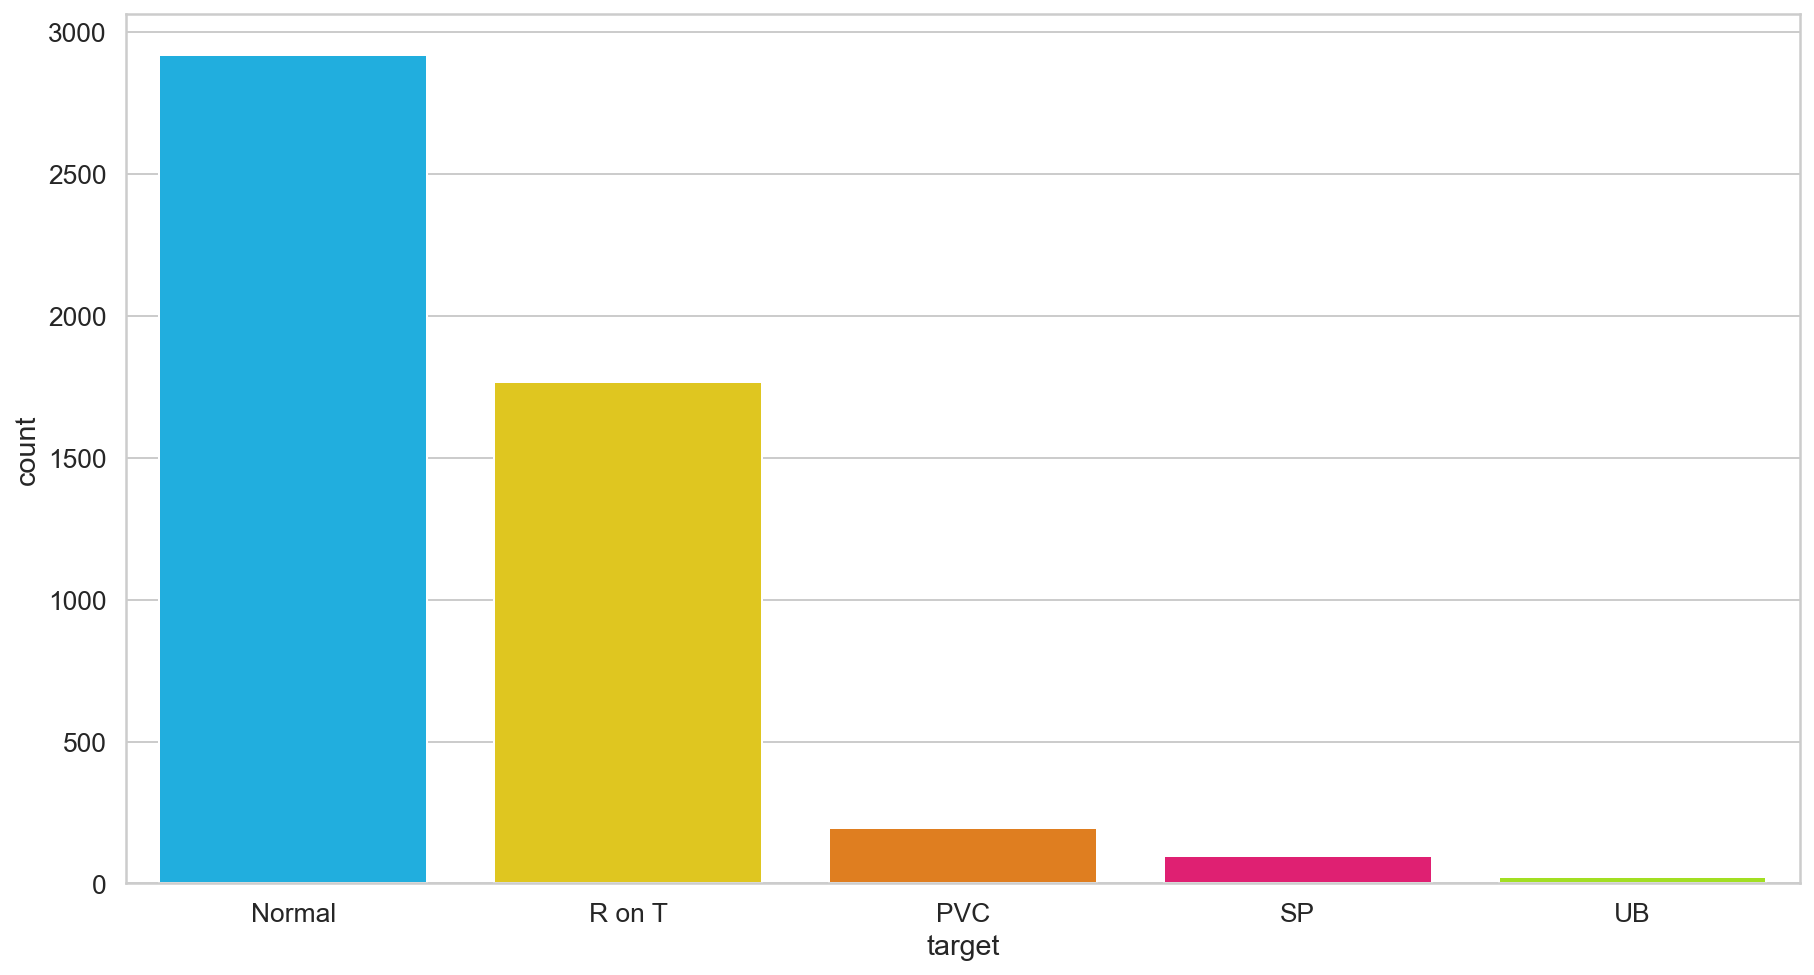

In [38]:
ax = sns.countplot(x="target", data=df,
                   order = df['target'].value_counts().index)
ax.set_xticklabels(class_names)

### 通过统计分析，我们发现普通类的样本最多。这个结果是非常理想的，也是意料之中的（异常检测中的异常往往是最少的），又因为我们需要使用这些正常类的数据来训练模型。
### 接下来，我们看一下每个类的平均时间序列（前面和后面做一个标准差平滑）。
### 首先定义一个辅助绘图函数。

In [39]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    """
    param data:数据
    param class_name: 不同心跳类名
    param ax:画布
    """
    time_series_df = pd.DataFrame(data)
    # 平滑时间窗口
    smooth_path = time_series_df.rolling(n_steps).mean()
    # 路径偏差
    path_deviation = 2 * time_series_df.rolling(n_steps).std()
    # 以正负偏差上下定义界限
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]
    # 绘制平滑曲线
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
      path_deviation.index,
      under_line,
      over_line,
      alpha=.125)
    ax.set_title(class_name)

### 根据上面的定义的辅助函数，循环绘制每个心跳类的平滑曲线。

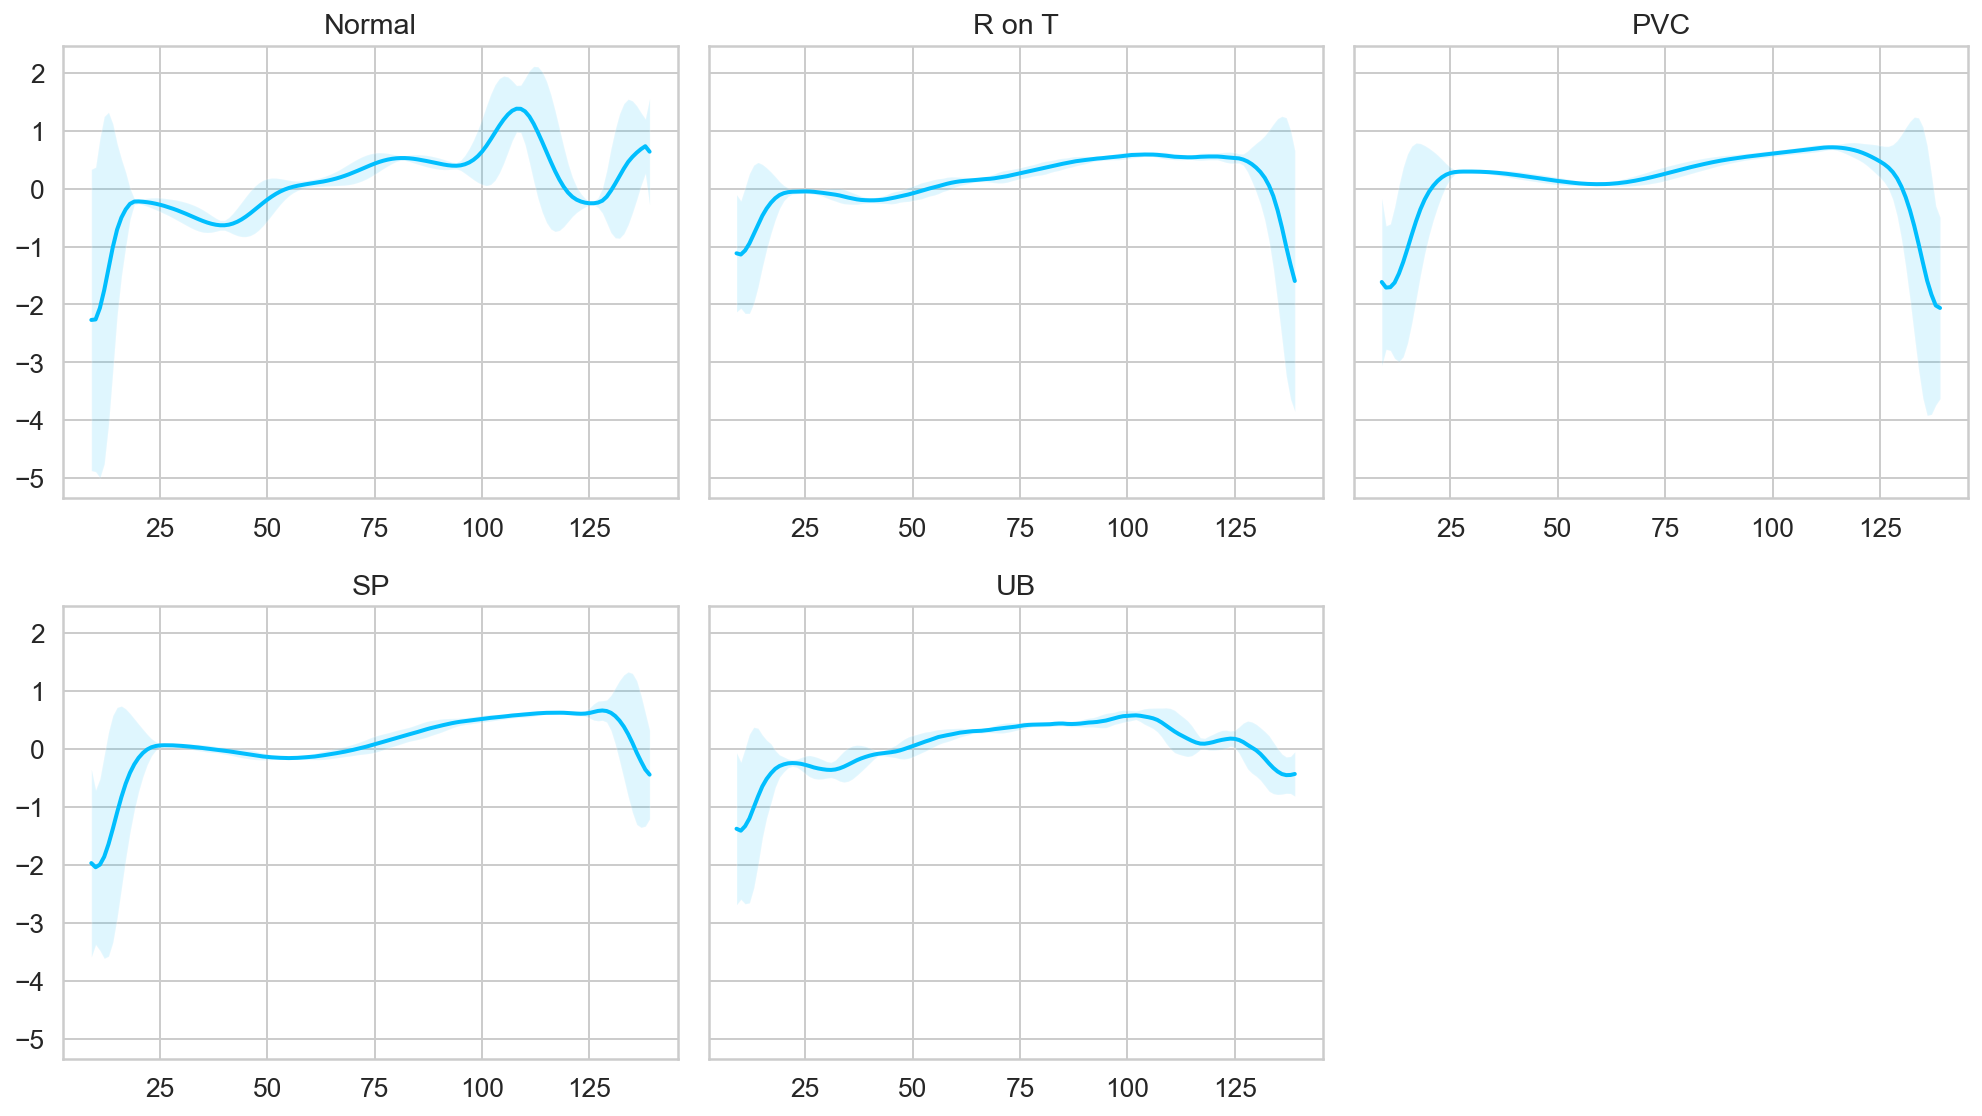

In [40]:
# 获取所有不同心跳类别
classes = df.target.unique()
# 定义画布
fig, axs = plt.subplots(
      nrows=len(classes) // 3 + 1,
      ncols=3,
      sharey=True,
      figsize=(14, 8))
# 循环绘制曲线
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
      .drop(labels='target', axis=1) \
      .mean(axis=0) \
      .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

### 根据上面五种心跳类的可视化结果看出，正常类具有与所有其他类明显不同的特征，这也许就是我们构建的模型能够检测出异常的关键所在。

# LSTM 自动编码器

### 我们将使用正常的心跳作为模型的训练数据，并记录重构损失。但首先需要准备数据。

### 数据预处理

In [41]:
# 获取所有正常的心跳并删除目标类的列。
normal_df = df[df.target == str(CLASS_NORMAL)
              ].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [42]:
# 合并所有其他类并将它们标记为异常。
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [43]:
#将正常类样本分为训练集、验证集和测试集。
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED)

In [44]:
#需要将样本转换为张量，使用它们来训练自动编码器。为此编写一个辅助函数来实现样本数据类型的转换，以便后续复用。
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [45]:
#每个时间序列将被转换为形状 序列长度 x *特征数量 *的二维张量 。在我们的例子中为140x1的二维张量。
#接下来将所有需要用到的数据集进行如上转换。
# _ 表示不需要该项
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### 构建 LSTM 自动编码器

#### 自动编码器的工作是获取一些输入数据，将其通过模型传递，并获得输入的重构，重构应该尽可能匹配输入。从某种意义上说，自动编码器试图只学习数据中最重要的特征，这里使用几个 LSTM 层(即LSTM Autoencoder)来捕获数据的时间依赖性。接下来我们一起看看如何将时间序列数据提供给自动编码器。为了将序列分类为正常或异常，需要设定一个阈值，并规定高于该阈值时，心跳是异常的。

### 重构损失
#### 当训练一个自动编码器时，模型目标是尽可能地重构输入。这里的目标是通过最小化损失函数来实现的（就像在监督学习中一样）。这里所使用的损失函数被称为重构损失。常用的重构损失是交叉熵损失和均方误差。接下来将以GitHub中的 LSTM Autoencoder为基础，并进行一些小调整。因为模型的工作是重建时间序列数据，因此该模型需要从编码器开始定义。

In [46]:
class Encoder(nn.Module):
  """
  定义一个编码器的子类，继承父类 nn.Modul
  """
  def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    # 使用双层LSTM
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True)
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True)

  def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))
  #   编码器使用两个LSTM层压缩时间序列数据输入。

In [47]:
#接下来，我们将使用Decoder对压缩表示进行解码。
class Decoder(nn.Module):
  """
  定义一个解码器的子类，继承父类 nn.Modul
  """
  def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True)

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True)
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)
    #编码器和解码器均包含两个 LSTM 层和一个提供最终重建的输出层。

In [48]:
# 编码器和解码器均包含两个 LSTM 层和一个提供最终重建的输出层。
# 这里将所有内容包装成一个易于使用的模块了。
class RecurrentAutoencoder(nn.Module):
    """
    定义一个自动编码器的子类，继承父类 nn.Module
    并且自动编码器通过编码器和解码器传递输入
    """
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [49]:
#自动编码器类已经定义好，接下来创建一个它的实例。
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

# 训练模型
### 接下来需要训练模型。下面为训练过程编写一个辅助函数train_model

In [50]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history


#### 在每个epoch中，训练过程为模型提供所有训练样本，并评估验证集上的模型效果。注意，这里使用的批处理大小为1 ，即模型一次只能得到一个序列。另外还记录了过程中的训练和验证集损失。
#### 值得注意的是，重构时做的是最小化L1损失，它测量的是 MAE（平均绝对误差），似乎比 MSE（均方误差）更好。
#### 最后，我们将获得具有最小验证误差的模型，并使用该模型进行接下来的异常检测预。现在开始做一些训练。

In [51]:
# 这一步耗时较长
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 65.41179131904181 val loss 56.174433451056885
Epoch 2: train loss 53.30891081269159 val loss 51.121476065990464


KeyboardInterrupt: 

### 绘制模型损失

绘制模型在训练和测试数据集上面的损失曲线。

NameError: name 'history' is not defined

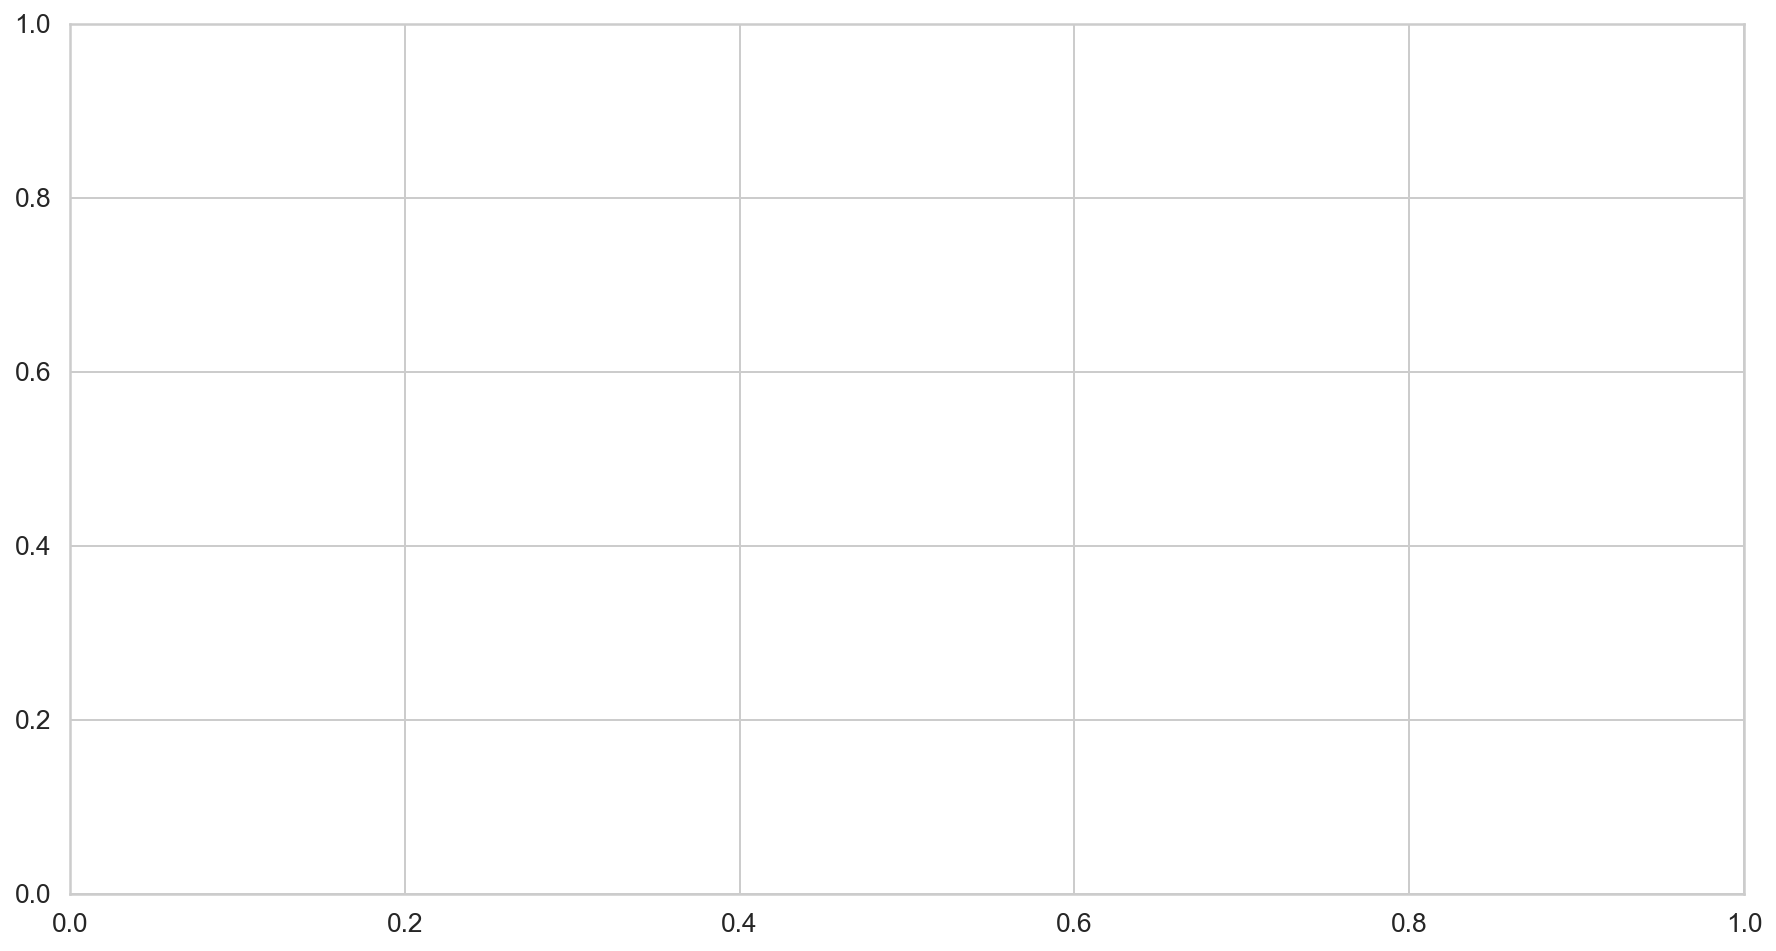

In [ ]:
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

# 保存模型

### 存储模型以备后用。模型保存是必须要做的，他是保存和避免我们宝贵工作不被浪费的重要步骤。

In [ ]:
ODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)
#如果要下载和加载预训练模型，请取消注释下一行。
# model = torch.load('model.pth')
# model = model.to(device)

# 设定阈值
### 有了训练好了的模型，可以看看训练集上的重构误差。同样编写一个辅助函数来使用模型预测结果。

In [ ]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

该预测函数遍历数据集中的每个样本并记录预测结果和损失。

In [ ]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

# 评估

### 利用上面设定的阈值，我们可以将问题转化为一个简单的二分类任务：
### 如果一个例子的重构损失低于阈值，我们将其归类为"正常"心跳
### 或者，如果损失高于阈值，我们会将其归类为**"异常"**

### 正常心跳

### 我们检查一下模型在正常心跳上的表现如何。这里使用新的测试集中的正常心跳。

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
#计算下模型预测正确的样本有多少。
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

# 异常心跳
### 我们对异常样本执行相同的操作，由于异常心跳和正常心跳的样本数量不一致，因此需要获得一个与正常心跳大小相同的子集，并对异常子集进行模型的预测。

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
#最后计算高于阈值的样本数量，而这些样本将被视为异常心跳数据。
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

# 样本对比观察
### 可以叠加真实的和重构的时间序列值，看看它们有多接近。得到相比的结果，可以针对一些正常和异常情况进行处理。


In [ ]:
# 定义辅助函数
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()
# 绘图
fig, axs = plt.subplots(
              nrows=2,
              ncols=6,
              sharey=True,
              sharex=True,
              figsize=(22, 8)
            )

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

# torch.unsqueeze 详解

In [ ]:
torch.unsqueeze(input, dim, out=None)

#### 返回一个新的张量，对输入的既定位置插入维度 1
#### 作用：扩展维度
#### 注意： 返回张量与输入张量共享内存，所以改变其中一个的内容会改变另一个。
#### 参数:
#### tensor (Tensor) – 输入张量
#### dim (int) – 插入维度的索引，如果dim为负，则将会被转化dim+input.dim()+1
#### out (Tensor, optional) – 结果张量

In [ ]:
x = torch.Tensor([1, 2, 3, 4])
torch.unsqueeze(x, 0)  
>>> tensor([[1., 2., 3., 4.]])
torch.unsqueeze(x, 1)
>>> tensor([[1.],
            [2.],
            [3.], 
            [4.]])

# torch.stack() 详解

### 沿着一个新维度对输入张量序列进行连接。序列中所有的张量都应该为相同形状。
### 简而言之：把多个二维的张量凑成一个三维的张量；多个三维的凑成一个四维的张量…以此类推，也就是在增加新的维度进行堆叠。

In [ ]:
outputs = torch.stack(inputs, dim=0) → Tensor

#### 参数:
#### inputs (sequence of Tensors) - 待连接的张量序列。
#### 注：python的序列数据只有list和tuple。函数中的输入inputs只允许是序列；且序列内部的张量元素，必须shape相等。
#### dim (int) 新的维度， 必须在0到len(outputs)之间。注：len(outputs)是生成数据的维度大小，也就是outputs的维度值。dim是选择生成的维度，必须满足0<=dim<len(outputs)；#### len(outputs)是输出后的tensor的维度大小。

In [ ]:
# 假设是时间步T1的输出
T1 = torch.tensor([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
# 假设是时间步T2的输出
T2 = torch.tensor([[10, 20, 30],
                  [40, 50, 60],
                  [70, 80, 90]])
torch.stack((T1,T2),dim=1)
>>> tensor([[[ 1,  2,  3],
...        [10, 20, 30]],
...
...       [[ 4,  5,  6],
...        [40, 50, 60]],
...
...       [[ 7,  8,  9],
...        [70, 80, 90]]])
torch.stack((T1,T2),dim=0)
>>> tensor([[[ 1,  2,  3],
...         [ 4,  5,  6],
...         [ 7,  8,  9]],
...
...        [[10, 20, 30],
...         [40, 50, 60],
...         [70, 80, 90]]])